In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import torch
from src.models import BabyCNN
from src.dataset import FloodDataprocessor, FloodDataset
from src.config import config
from sklearn.metrics import det_curve

In [2]:
config['Device'] = "cpu"
flood_data_processor = FloodDataprocessor(config)
flood_dataset = FloodDataset(config, flood_data_processor, "train")

Data Flood with save = False


In [3]:
i=0
X,y = flood_dataset.__getitem__(i)
while y.sum()<6:
    i+=1
    X,y = flood_dataset.__getitem__(i)

print(f"X: {X.shape}, y: {y.shape}, y sum = {y.sum()}")

X: torch.Size([16, 4, 4]), y: torch.Size([4, 4]), y sum = 6.0


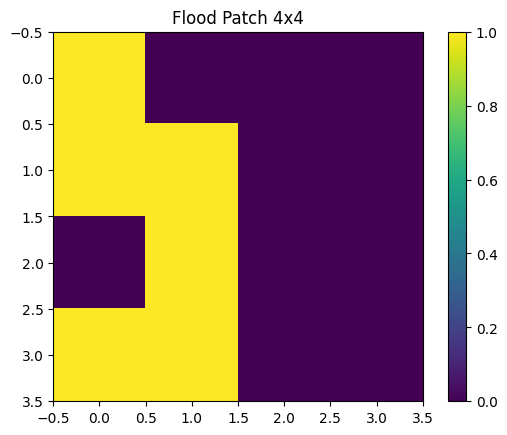

In [4]:
plt.imshow(y.numpy())
plt.title("Flood Patch 4x4")
plt.colorbar()
plt.show()

In [5]:
config['NbFeatures'] = X.shape[0]
model = BabyCNN({}, config)
model.load_state_dict(torch.load("data/checkpoint_4.pth", map_location="cpu"))

<All keys matched successfully>

/opt/conda/envs/flood-prediction/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


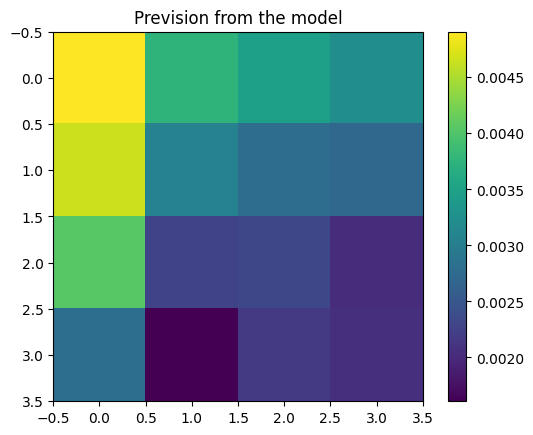

In [6]:
import torch.nn as nn
plt.imshow(nn.Sigmoid()(model(X.unsqueeze(0))).squeeze().detach().numpy())
plt.title("Prevision from the model")
plt.colorbar()
plt.show()

## Generate validation prediction

In [7]:
from src.training_functions import Trainer
from src.dataset import split_train_val


train_loader, val_loader = split_train_val(flood_dataset, config, seed=0, size=0.01)
trainer = Trainer(config, train_loader, val_loader)
y_true, y_prob, y_pred = trainer.evaluate(val_loader, model, 0.05, return_pred=True)
auc = trainer.evaluate(val_loader, model, 0.05, False)

Losses | AUC = 0.9094688636501975, shape: (253201,), nb of true flood events: 1030.0, proportion: 0.004067914423718706, mean prob: 0.0029142252169549465, max prob: 0.34353992342948914
Losses | AUC = 0.9094688636501975, shape: (253201,), nb of true flood events: 1030.0, proportion: 0.004067914423718706, mean prob: 0.002914224285632372, max prob: 0.34353992342948914


## False positives analysis

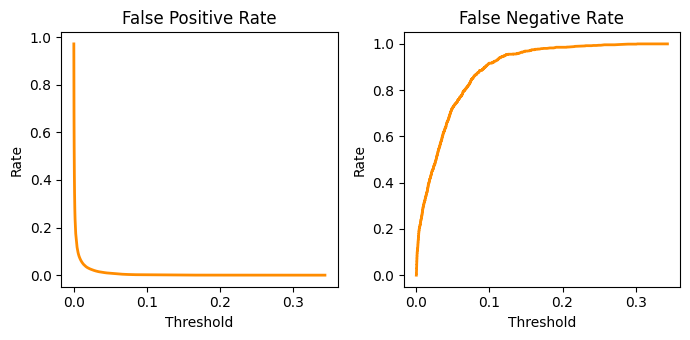

In [8]:
fpr, fnr, thresholds = det_curve(y_true,y_prob,pos_label=1)

plt.figure(figsize=((7,3.5)))
# using subplot function and creating plot one
plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.plot(thresholds, fpr, color='darkorange', lw=2)
plt.title('False Positive Rate')
plt.ylabel('Rate')
plt.xlabel('Threshold')
 
# using subplot function and creating plot two
# row 1, column 2, count 2
plt.subplot(1, 2, 2)
 
# g is for green color
plt.plot(thresholds, fnr, color='darkorange', lw=2)
plt.title('False Negative Rate')
plt.ylabel('Rate')
plt.xlabel('Threshold')
 
plt.tight_layout()

# show plot
plt.savefig("figs/error_rates.pdf")

## Calibration analysis

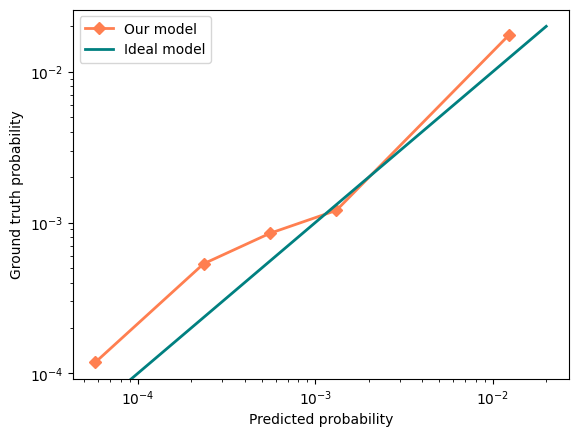

In [9]:
idx_y_prob_ord = np.argsort(y_prob)
y_prob_ord = y_prob[idx_y_prob_ord]
y_true_ord = y_true[idx_y_prob_ord]

bins_prob = [bin.mean() for bin in np.array_split(y_prob_ord,5)]
bins_true = [bin.mean() for bin in np.array_split(y_true_ord,5)]

plt.plot(bins_prob,bins_true,color = "Coral", marker = 'D', linewidth=2, label="Our model")
plt.plot([0,0.02],[0,0.02],color = "teal", linewidth=2, label="Ideal model")
plt.legend(loc="best")

plt.xscale('log')
plt.yscale('log')
plt.ylabel("Ground truth probability")
plt.xlabel("Predicted probability")

plt.savefig("figs/calibration.pdf")


## Validity of the model

In [10]:
from sklearn.metrics import roc_auc_score
static = xr.load_dataset('data/static_Full_Rez.nc')
name_features = list(static.band.to_numpy()) + ['precipitations', 'temperature']
name_features

['soilgrid_bdod',
 'soilgrid_cfvo',
 'soilgrid_silt',
 'soilgrid_clay',
 'soilgrid_sand',
 'depth_to_bedrock',
 'altitude',
 'aspect',
 'slope',
 'water_density',
 'watershed',
 'topological_catchment_areas',
 'dist_sea',
 'dist_water',
 'precipitations',
 'temperature']

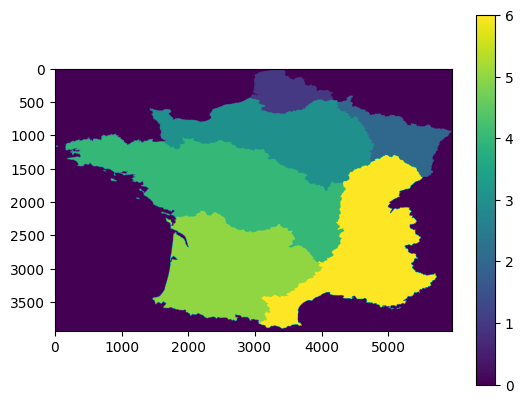

In [11]:
plt.imshow(static.__xarray_dataarray_variable__[10])
plt.colorbar()
plt.show()

In [12]:
patches_X, patches_prob, patches_true = trainer.evaluate(val_loader, model, 0.05, return_all=True)

X_rescaled = patches_X * np.array(static.std().to_array()) + np.array(static.mean().to_array())

Losses | AUC = 0.9094688636501975, shape: (253201,), nb of true flood events: 1030.0, proportion: 0.004067914423718706, mean prob: 0.002914224751293659, max prob: 0.34353992342948914


In [13]:
basin_auc = np.zeros(7)
for basin in range(1, 7):
    basin_true = patches_true[X_rescaled[:, 10] == basin]
    basin_prob = patches_prob[X_rescaled[:, 10] == basin]
    mask = np.where(basin_true == -1)
    basin_true = np.delete(basin_true, mask)
    basin_prob = np.delete(basin_prob,mask)
    basin_auc[basin] = roc_auc_score(basin_true, basin_prob)
    print(basin_auc[basin])

0.8113215820398141
0.9166095655748938
0.9586802860838469
0.9539441226678368
0.9477410045191618
0.865994699010731


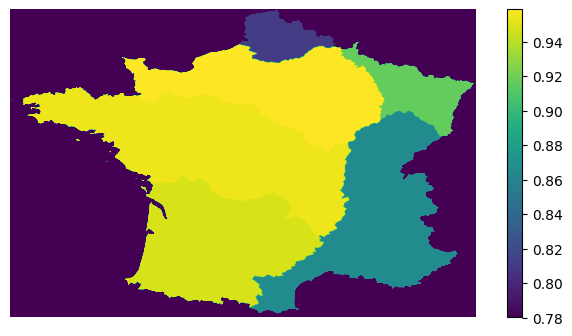

In [14]:
plt.figure(figsize = (8,4))
plt.imshow(basin_auc[np.array(static.__xarray_dataarray_variable__[10], dtype = int)], vmin=0.78)
plt.axis('off')
plt.colorbar()
plt.savefig("figs/basin.pdf", bbox_inches="tight")

In [15]:
altitude_bins=np.array([0, 5, 25, 50, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 4500])
altitude_auc = np.zeros(len(altitude_bins)-1)
for i in range(len(altitude_bins)-1):
    altitude_true = patches_true[(X_rescaled[:, 6] >= altitude_bins[i]) & (X_rescaled[:, 6] < altitude_bins[i+1])]
    altitude_prob = patches_prob[(X_rescaled[:, 6] >= altitude_bins[i]) & (X_rescaled[:, 6] < altitude_bins[i+1])]
    mask = np.where(altitude_true == -1)
    altitude_true = np.delete(altitude_true, mask)
    altitude_prob = np.delete(altitude_prob,mask)
    print(f"Between { altitude_bins[i]}m and { altitude_bins[i+1]}m: {len(altitude_true)} samples")
    try:
        altitude_auc[i] = roc_auc_score(altitude_true, altitude_prob)
    except ValueError:
        altitude_auc[i] = 0
    print(altitude_auc[i])
        

Between 0m and 5m: 19624 samples
0.8945020928004215
Between 5m and 25m: 13839 samples
0.9141672959125243
Between 25m and 50m: 11643 samples
0.9338975945949278
Between 50m and 100m: 18052 samples
0.9354700854700854
Between 100m and 150m: 19608 samples
0.8896789308887608
Between 150m and 200m: 20822 samples
0.8067726650632445
Between 200m and 300m: 27126 samples
0.7190396201482676
Between 300m and 500m: 29374 samples
0.7142505575054047
Between 500m and 750m: 28677 samples
0.7124827095856765
Between 750m and 1000m: 22088 samples
0.8481747438059101
Between 1000m and 1500m: 25850 samples
0.6967893106119287
Between 1500m and 2000m: 10280 samples
0.23885970033080367
Between 2000m and 4500m: 5384 samples
0.381385844324726


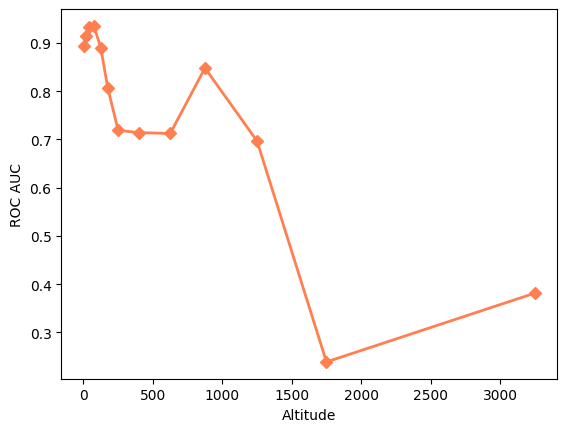

In [16]:

plt.plot((altitude_bins[1:] + altitude_bins[:-1])/2, altitude_auc, color = "Coral", marker = 'D', linewidth=2)
plt.ylabel("ROC AUC")
plt.xlabel("Altitude")
plt.savefig("figs/altitude.pdf")

## Feature importance analysis v2: permutation importance

In [17]:
feature_importance = np.zeros(16)
for feature in range(16):
    #y_true_shuffle, y_prob_shuffle, y_pred_shuffle = trainer.evaluate(val_loader, model, 0.05, True,  shuffle_dim=feature)
    auc_shuffle = trainer.evaluate(val_loader, model, 0.05, False, shuffle_dim=feature)
    feature_importance[feature] = auc - auc_shuffle
    print(f"AUC degradation by shuffling feature {feature}: {feature_importance[feature]}")


Losses | AUC = 0.9094593732493049, shape: (253201,), nb of true flood events: 1030.0, proportion: 0.004067914423718706, mean prob: 0.002893151482567191, max prob: 0.3323702812194824
AUC degradation by shuffling feature 0: 9.490400892597783e-06
Losses | AUC = 0.9098692738665198, shape: (253201,), nb of true flood events: 1030.0, proportion: 0.004067914423718706, mean prob: 0.0028124009259045124, max prob: 0.3315054178237915
AUC degradation by shuffling feature 1: -0.0004004102163223111
Losses | AUC = 0.9094790124115578, shape: (253201,), nb of true flood events: 1030.0, proportion: 0.004067914423718706, mean prob: 0.0028780444990843534, max prob: 0.33234429359436035
AUC degradation by shuffling feature 2: -1.0148761360295744e-05
Losses | AUC = 0.9093704098848319, shape: (253201,), nb of true flood events: 1030.0, proportion: 0.004067914423718706, mean prob: 0.0030062629375606775, max prob: 0.3712114095687866
AUC degradation by shuffling feature 3: 9.845376536565809e-05
Losses | AUC = 0.

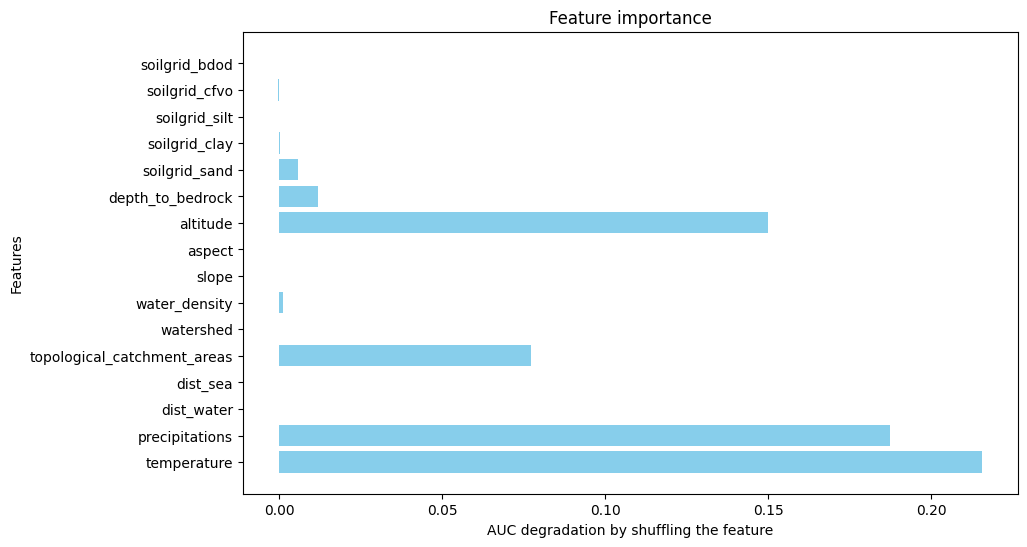

In [18]:
features = name_features
importances = feature_importance

# Créer le plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('AUC degradation by shuffling the feature')
plt.ylabel('Features')
plt.title('Feature importance')
plt.gca().invert_yaxis()

plt.savefig("figs/features_importance.pdf", bbox_inches="tight")